In [86]:
import os
import joblib

import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler, OneHotEncoder, power_transform
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.compose import TransformedTargetRegressor

import shap
import optuna
import category_encoders as ce
import optuna.visualization as vis

import xgboost as xgb
import lightgbm as lgb
import catboost as cat

from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

In [6]:
train = pd.read_csv('../data/simple_train1.csv')
test = pd.read_csv('../data/simple_test1.csv')

In [7]:
print(train.info())
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287836 entries, 0 to 287835
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Year                287836 non-null  int64  
 1   OG                  287836 non-null  int64  
 2   Dept                287836 non-null  int64  
 3   UC                  287836 non-null  int64  
 4   Union               287836 non-null  int64  
 5   JF                  287836 non-null  int64  
 6   Job                 287836 non-null  int64  
 7   Salaries            287836 non-null  int64  
 8   Overtime            287836 non-null  int64  
 9   H/D                 287836 non-null  float64
 10  YT                  287836 non-null  int64  
 11  Total_Compensation  287836 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 26.4 MB
None


,Year,OG,Dept,UC,Union,JF,Job,Salaries,Overtime,H/D,YT,Total_Compensation
0,2,0,45,250,57,28,673,12196,0,0.00,0,16158
1,0,0,45,39,63,23,1014,74639,2820,12703.31,1,115784
2,2,2,5,21,52,6,913,100554,0,12424.50,0,144708
3,3,5,42,911,47,35,927,140164,52754,13043.87,1,242323
4,0,6,38,21,52,22,498,58813,0,7655.28,0,82106


In [32]:
# feats = ['Salaries', 'Overtime', 'H/D', 'Union', 'OG', 'JF']
feats = test.columns.tolist()

X = train.drop('Total_Compensation', axis=1).loc[:, feats]
y = train['Total_Compensation']

In [65]:
X['is_overtime'] = X['Overtime'].apply(lambda x: 1 if x == 0 else 0)

In [113]:
te = ce.TargetEncoder(
    cols=['Year', 'OG', 'Dept', 'UC', 'Union', 'JF', 'Job', 'YT', 'is_overtime'],
)

X = te.fit_transform(X, y)

In [114]:
print(X.info())
X.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287836 entries, 0 to 287835
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Year         287836 non-null  float64
 1   OG           287836 non-null  float64
 2   Dept         287836 non-null  float64
 3   UC           287836 non-null  float64
 4   Union        287836 non-null  float64
 5   JF           287836 non-null  float64
 6   Job          287836 non-null  float64
 7   Salaries     287836 non-null  int64  
 8   Overtime     287836 non-null  int64  
 9   H/D          287836 non-null  float64
 10  YT           287836 non-null  float64
 11  is_overtime  287836 non-null  float64
dtypes: float64(10), int64(2)
memory usage: 26.4 MB
None


,Year,OG,Dept,UC,Union,JF,Job,Salaries,Overtime,H/D,YT,is_overtime
0,97971.129197,94925.794916,94944.106126,73493.859735,73462.576515,84924.925394,16452.486486,12196,0,0.00,98634.119305,80748.772117
1,98141.315925,94925.794916,94944.106126,121648.785321,121283.405041,118199.934494,108863.145062,74639,2820,12703.31,97346.701478,120458.324518
2,97971.129197,90982.550938,90521.329746,106685.830087,106517.406200,94363.781135,118725.977273,100554,0,12424.50,98634.119305,80748.772117


In [101]:
test['is_overtime'] = test['Overtime'].apply(lambda x: 1 if x == 0 else 0)

In [103]:
test = te.transform(test)

In [104]:
print(test.info())
test.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47860 entries, 0 to 47859
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Year         47860 non-null  int64  
 1   OG           47860 non-null  int64  
 2   Dept         47860 non-null  float64
 3   UC           47860 non-null  float64
 4   Union        47860 non-null  float64
 5   JF           47860 non-null  float64
 6   Job          47860 non-null  float64
 7   Salaries     47860 non-null  int64  
 8   Overtime     47860 non-null  int64  
 9   H/D          47860 non-null  float64
 10  YT           47860 non-null  int64  
 11  is_overtime  47860 non-null  int64  
dtypes: float64(6), int64(6)
memory usage: 4.4 MB
None


,Year,OG,Dept,UC,Union,JF,Job,Salaries,Overtime,H/D,YT,is_overtime
0,3,6,95249.637965,63413.572186,63413.598208,94159.567628,82058.931686,74526,0,13068.800000,1,1
1,0,4,64892.151466,17425.514240,17448.927149,14247.843251,12865.287396,7219,0,3328.053046,0,1


In [96]:
def cross_validate(model, X, y, n_folds=10):
    scores = []
    kf = KFold(n_splits=n_folds)

    for fold, (train_index, valid_index) in tqdm(enumerate(kf.split(X)), total=n_folds):

        train_x, valid_x = X.iloc[train_index], X.iloc[valid_index]
        train_y, valid_y = y[train_index], y[valid_index]

        model.fit(
            train_x, 
            train_y, 
            eval_set=[(valid_x, valid_y)], 
            eval_metric='rmse', 
            verbose=100, 
            early_stopping_rounds=300
        )

        preds = model.predict(valid_x)
        score = np.sqrt(mean_squared_error(valid_y, preds,))
        scores.append(score)
        print(f"Fold {fold + 1}: {score:.6f}")

    print(f'Mean Score: {np.mean(scores):.6f}')

In [100]:
def get_kfold_prediction(model, X, y, test_data, n_folds=10):
    scores = []
    oof_preds = np.zeros(test_data.shape[0])
    kf = KFold(n_splits=n_folds)

    for fold, (train_index, valid_index) in tqdm(enumerate(kf.split(X)), total=n_folds):

        train_x, valid_x = X.iloc[train_index], X.iloc[valid_index]
        train_y, valid_y = y[train_index], y[valid_index]

        model.fit(
            train_x, 
            train_y, 
            eval_set=[(valid_x, valid_y)], 
            eval_metric='rmse', 
#             use_best_model=True,
            early_stopping_rounds=300,
            verbose=100,
        )

        preds = model.predict(valid_x)

        # change metric according to requirement
        score = np.sqrt(mean_squared_error(valid_y, preds))
        scores.append(score)

        # change this according to requirement
        oof_preds += model.predict(test_data) / n_folds

        print(f"Fold {fold + 1}: {score:.6f}")

    print(f'Mean Score: {np.mean(scores)}')

    return oof_preds

In [81]:
# change the objective and metric

lgb_params = {
    'metric': 'rmse',
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'n_estimators': 10000,
    'learning_rate': 0.25,
    'max_depth': 7,
    'num_leaves': 64,  
    'max_bin': 512,
    'min_child_samples': 32,
    'subsample': 0.9,
    'reg_alpha': 0.01,
    'reg_lambda': 0.5,
    'early_stopping_round': 300,
    'categorical_feature': [0, 1, 10, 11],
    # 'min_child_weight': 0.01,
    # 'colsample_bytree': 0.8,
    # 'colsample_bynode': 0.8,
    # 'random_strength': 2,
    # 'one_hot_max_size': 4,
    'verbose': -1,
    'seed': 20,
    'n_jobs': -1,
}

In [82]:
lgb_model = lgb.LGBMRegressor(**lgb_params)

In [83]:
cross_validate(lgb_model, X, y)

  0%|          | 0/10 [00:00<?, ?it/s]

Fold 1: 5770.850555
Fold 2: 6015.524326
Fold 3: 5617.931253
Fold 4: 6165.462996
Fold 5: 6127.304210
Fold 6: 5648.117410
Fold 7: 6004.663277
Fold 8: 5917.802465
Fold 9: 5965.257129
Fold 10: 5752.398504
Mean Score: 5898.531213


Random Forest Scores: 


- using all the columns and default parameters => 6341.678449906489

LGBM Regressor scores:
- target encoding, using all columns => 5898.531213

In [48]:
%%time

lgb_model.fit(X, y)

CPU times: user 9min 17s, sys: 6.33 s, total: 9min 23s
Wall time: 2min 38s


LGBMRegressor(categorical_feature=[0, 1, 2, 3, 4, 5, 6, 10], learning_rate=0.25,
              max_bin=512, max_depth=7, metric='rmse', min_child_samples=32,
              n_estimators=10000, num_leaves=64, objective='regression',
              reg_alpha=0.01, reg_lambda=0.5, seed=1234, subsample=0.75,
              verbose=-1)

In [50]:
feat_imp = pd.DataFrame({
    'feat': X.columns.tolist(),
    'imp': lgb_model.feature_importances_
})

feat_imp

,feat,imp
0,Year,12329
1,OG,985
2,Dept,18854
3,UC,5242
4,Union,3424
5,JF,5475
6,Job,52089
7,Salaries,142998
8,Overtime,108026
9,H/D,155389


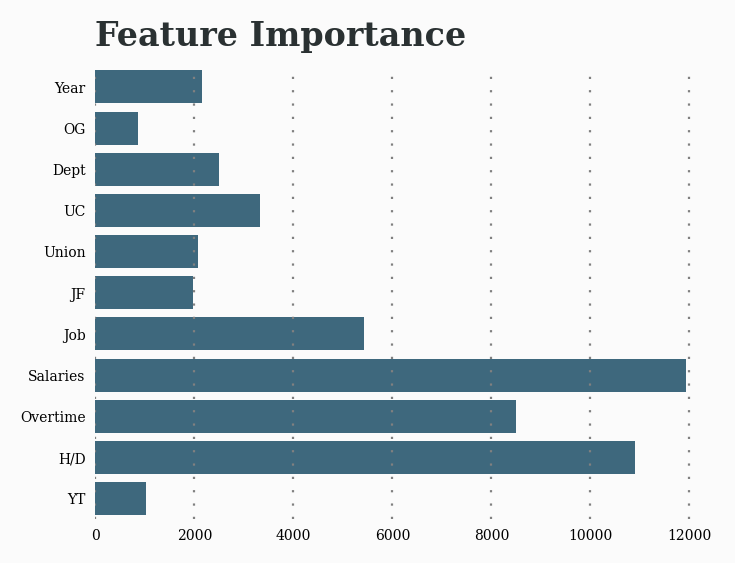

In [68]:
feat_imp = pd.DataFrame({
    'feat': X.columns.tolist()[:-1],
    'imp': lgb_model.feature_importances_
})

# Setting up figure and axes
fig = plt.figure(figsize=(4, 3), dpi=200) # create figure
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0, hspace=1)
ax0 = fig.add_subplot(gs[0, 0])


# # Change background color
background_color = "#fbfbfb"
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color)

c = ['#336b87'] * 10
# c[-2] = '#2a3132'
# c[-4] = '#763626'

feat_imp_plot = sns.barplot(data=feat_imp, x='imp', y='feat', ax=ax0, palette=c)
# ax0.bar_label(feat_imp_plot, )
plt.draw()

ax0.set_xticklabels(ax0.get_xticklabels(), fontfamily='serif', rotation=0, fontsize=5)
ax0.set_yticklabels(ax0.get_yticklabels(), fontfamily='serif', rotation=0, fontsize=5)
ax0.set_ylabel('')
ax0.set_xlabel('')
ax0.tick_params(axis='both', which='both', length=0)
ax0.grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1,5))
for loc in ['left', 'top', 'right', 'bottom']:
    ax0.spines[loc].set_visible(False)

ax0.text(0, -1, 'Feature Importance', fontsize=12, fontfamily='serif', 
         fontweight='bold', color='#2a3132')
# ax0.text(0, 0.88, 
#          '''
#          All the features have positive skewness except 
#          damage ratio, and we see that err_malign shows 
#          very high skewness.
#          ''',
#          fontsize=5,
#          fontfamily='serif',
#          color='#2a3132',
# )

plt.tight_layout()
plt.show()

In [53]:
preds = lgb_model.predict(test)

In [54]:
sub = pd.DataFrame({
    'Compensation': preds
})
print(sub.shape)
sub.head()

(47860, 1)


,Compensation
0,108034.204306
1,11306.776416
2,6138.681596
3,9666.870581
4,162537.803905


In [55]:
sub.to_csv('../submissions/sub3.csv', index=False)

In [115]:
# change the objective

xgb_params = {
    'objective': 'reg:squarederror',
    'booster': 'gbtree',
    'n_estimators': 5000,
    'max_depth': 6,
    'learning_rate': 0.2,
    # 'gamma': 10,
    # 'min_child_weight': 0.4,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    # 'colsample_bylevel': 0.4,
    # 'colsample_bynode': 0.6,
    'reg_alpha': 0.01,
    'reg_lambda': 0.5,
    # 'scale_pos_weight': 4,
    # 'importance_type': 'gain',
    # 'max_delta_step': ,
    # 'base_score': ,
    # 'tree_method': 'auto',
    # 'missing': ,
    # 'num_parallel_tree': ,
    # 'monotone_constraints': ,
    # 'interaction_constraints': ,
    'n_jobs': -1,
    'random_state': 1234,
    'verbosity': 1,
}

In [116]:
xgb_model = xgb.XGBRegressor(**xgb_params)

In [99]:
cross_validate(xgb_model, X, y)

  0%|          | 0/10 [00:00<?, ?it/s]

[0]	validation_0-rmse:95239.40625
[100]	validation_0-rmse:5884.22070
[200]	validation_0-rmse:5819.94824
[300]	validation_0-rmse:5776.20068
[400]	validation_0-rmse:5758.09912
[500]	validation_0-rmse:5755.84375
[600]	validation_0-rmse:5754.83691
[700]	validation_0-rmse:5756.99268
[800]	validation_0-rmse:5747.60498
[900]	validation_0-rmse:5750.91357
[1000]	validation_0-rmse:5756.81055
[1100]	validation_0-rmse:5759.99268
[1134]	validation_0-rmse:5759.86816
Fold 1: 5745.848255
[0]	validation_0-rmse:95161.04688
[100]	validation_0-rmse:6143.94873
[200]	validation_0-rmse:6015.56250
[300]	validation_0-rmse:5973.08545
[400]	validation_0-rmse:5952.25830
[500]	validation_0-rmse:5948.59863
[600]	validation_0-rmse:5923.90772
[700]	validation_0-rmse:5921.73682
[800]	validation_0-rmse:5927.84375
[900]	validation_0-rmse:5917.44580
[1000]	validation_0-rmse:5918.58447
[1100]	validation_0-rmse:5919.22168
[1200]	validation_0-rmse:5911.47168
[1300]	validation_0-rmse:5911.60400
[1400]	validation_0-rmse:5918.

KeyboardInterrupt: 

In [117]:
xgb_preds = get_kfold_prediction(xgb_model, X, y, test)

  0%|          | 0/10 [00:00<?, ?it/s]

[0]	validation_0-rmse:95229.62500
[100]	validation_0-rmse:5852.30664
[200]	validation_0-rmse:5785.24561
[300]	validation_0-rmse:5753.89258
[400]	validation_0-rmse:5720.81299
[500]	validation_0-rmse:5720.48047
[600]	validation_0-rmse:5728.66602
[700]	validation_0-rmse:5740.99170
[800]	validation_0-rmse:5727.12549
[900]	validation_0-rmse:5759.47168
[924]	validation_0-rmse:5747.73242
Fold 1: 5711.696004
[0]	validation_0-rmse:95156.03906
[100]	validation_0-rmse:6098.19434
[200]	validation_0-rmse:6006.28320
[300]	validation_0-rmse:5999.61084
[400]	validation_0-rmse:5997.67139
[500]	validation_0-rmse:5992.53955
[600]	validation_0-rmse:5960.90820
[700]	validation_0-rmse:5945.39307
[800]	validation_0-rmse:5961.31103
[900]	validation_0-rmse:5946.08691
[1000]	validation_0-rmse:5947.88086
[1100]	validation_0-rmse:5955.99951
[1200]	validation_0-rmse:5962.92432
[1228]	validation_0-rmse:5965.20020
Fold 2: 5943.606578
[0]	validation_0-rmse:95956.51562
[100]	validation_0-rmse:5799.80664
[200]	validati

5856.072713052717

In [118]:
xgb_preds

array([109858.77539062,  12781.55871582,   7531.59191895, ...,
        77187.46142578, 102030.42675781, 185912.22265625])

In [119]:
sub = pd.DataFrame({
    'Compensation': xgb_preds
})
print(sub.shape)
sub.head()

(47860, 1)


,Compensation
0,109858.775391
1,12781.558716
2,7531.591919
3,10042.241333
4,158642.563477


In [120]:
sub.to_csv('../submissions/xgb_sub2.csv', index=False)